# Custom dataset - 2 classes (daisy and Dandilion)

This architecture is a simple feedforward neural network designed for image classification tasks with two classes. The model takes RGB images of size 256x256 and outputs probability scores for each class using the softmax function.

In [11]:
!pip install scikit-learn -q
!pip install numpy -q
!pip install matplotlib -q
!pip install torchvision -q
!pip install torch -q

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(10)


In [3]:
# Define the neural network architecture
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(3 * 256 * 256, 128)  # Assuming input images are RGB and 256x256
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 2)  # Output layer with 2 classes
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 3 * 256 * 256)  # Flatten the input images (reshapes the input tensor to have a size of (batch_size, 3 * 256 * 256)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x


In [4]:
# Set up data transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root, transform=transform)  #This ensures that every image in the dataset is resized, converted to a tensor, and normalized before being used in the training or testing process.

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


In [6]:
pwd

'/Users/mac/Desktop/NN/Image_classification_using_pytorch'

In [7]:
ls

1_numpyarray_vs_tensor.ipynb     binary_classification_model.pth
Flowers_Classification_dataset/  test.jpg
L-3_simple_neural_network.ipynb


In [8]:
# Define data loaders
train_dataset = CustomDataset(root='Flowers_Classification_dataset/train', transform=transform)
test_dataset = CustomDataset(root='Flowers_Classification_dataset/val', transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [9]:
# Instantiate the model, loss function, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


Epoch [1/5], Training Loss: 0.7252, Validation Loss: 0.7276
Epoch [2/5], Training Loss: 0.7029, Validation Loss: 0.7312
Epoch [3/5], Training Loss: 0.6863, Validation Loss: 0.7309
Epoch [4/5], Training Loss: 0.6774, Validation Loss: 0.7410
Epoch [5/5], Training Loss: 0.6643, Validation Loss: 0.7196
Accuracy: 0.5769, Precision: 0.5855, Recall: 0.5769, F1 Score: 0.5049


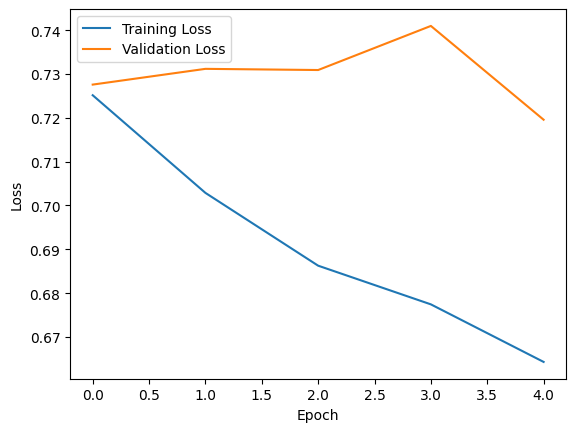

In [10]:
# Training the model
num_epochs = 5
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    average_train_loss = running_loss / len(train_loader)
    train_losses.append(average_train_loss)

    # Validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

    average_valid_loss = valid_loss / len(test_loader)
    valid_losses.append(average_valid_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Training Loss: {average_train_loss:.4f}, '
          f'Validation Loss: {average_valid_loss:.4f}')

# Evaluate the model
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

evaluate_model(model, test_loader)

# Visualize training and validation curves
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'binary_classification_model.pth')
